# Cosmological Forecasts for PFS

In [1]:
import os
import h5py
import numpy as np

In [2]:
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
quijote_thetas = {
        'Mnu': [0.1, 0.2, 0.4], # +, ++, +++
        'Ob': [0.048, 0.050], # others are - +
        'Ob2': [0.047, 0.051], # others are - +
        'Om': [0.3075, 0.3275],
        'h': [0.6511, 0.6911],
        'ns': [0.9424, 0.9824],
        's8': [0.819, 0.849] }


def read_quijote(obs, cosmo, kmax, rsd=2, z=1.0): 
    data_vector = []
    if 'pk' in obs: 
        f = h5py.File(os.path.join('/tigress/chhahn/emanu/bk', 'plk.rsd%i.%s.z%.1f.hdf5' % (rsd, cosmo, z)), 'r')
        k = f['k'][...]
        p0k = f['p0k'][...]
        p2k = f['p2k'][...]
        data_vector.append(np.concatenate([p0k, p2k], axis=1)[:,np.concatenate([k, k]) < kmax])
    if 'bk' in obs: 
        f = h5py.File(os.path.join('/tigress/chhahn/emanu/bk', 'b0k.rsd%i.%s.z%.1f.hdf5' % (rsd, cosmo, z)), 'r')
        kf = 2*np.pi/1000.
        k1 = f['k1'][...] * kf
        k2 = f['k2'][...] * kf
        k3 = f['k3'][...] * kf
        b123 = f['b123'][...]
        data_vector.append(b123[:, (k1 < kmax) & (k2 < kmax) & (k3 < kmax)])
    return np.concatenate(data_vector, axis=1)


def dObsdtheta(obs, theta, kmax, z=1.0, log=False): 
    # d P_ell / d theta or d B0 / d theta
    if theta == 'Mnu': 
        bk_fid, bk_p0, bk_p1, bk_p2 = [], [], [], []
        for irsd in range(3): 
            bk_fid.append(read_quijote(obs, 'fiducial_ZA', kmax, rsd=irsd, z=z))
            bk_p0.append(read_quijote(obs, 'Mnu_p', kmax, rsd=irsd, z=z))
            bk_p1.append(read_quijote(obs, 'Mnu_pp', kmax, rsd=irsd, z=z))
            bk_p2.append(read_quijote(obs, 'Mnu_ppp', kmax, rsd=irsd, z=z))            
        
        bk_fid = np.mean(np.concatenate(bk_fid, axis=0), axis=0)
        bk_p0 = np.mean(np.concatenate(bk_p0, axis=0), axis=0)
        bk_p1 = np.mean(np.concatenate(bk_p1, axis=0), axis=0)
        bk_p2 = np.mean(np.concatenate(bk_p2, axis=0), axis=0)     
        
        if not log: 
            return (-21.*bk_fid + 32*bk_p0 - 12*bk_p1 + bk_p2)/1.2
        else: 
            return (-21.*np.log(bk_fid) + 32*np.log(bk_p0) - 12*np.log(bk_p1) + np.log(bk_p2))/1.2
    elif theta == 'b1': 
        bk_fid = np.mean(read_quijote(obs, 'fiducial', kmax, rsd=2, z=z), axis=0)
        if obs == 'pk': 
            deriv = 2. * bk_fid
        elif obs == 'bk': 
            deriv = 3. * bk_fid
        elif obs == 'pkbk': 
            n_pk = read_quijote('pk', 'fiducial', kmax, rsd=2, z=z).shape[1]
            deriv = bk_fid
            deriv[:n_pk] *= 2.
            deriv[n_pk:] *= 3.
        if not log: 
            return deriv
        else: 
            return np.log(deriv)
    elif theta == 'b2': 
        if obs != 'bk': raise ValueError
        # B = b1 B + b2 (P1P2 + P2P3 + P3P1) + g2 (K12 P1 P2 + K23 P2 P3 + K31 P3 P1)
        f = h5py.File(os.path.join('/tigress/chhahn/emanu/bk', 'b0k.rsd2.fiducial.z%.1f.hdf5' % z), 'r')
        kf = 2*np.pi/1000.
        k1 = f['k1'][...] * kf
        k2 = f['k2'][...] * kf
        k3 = f['k3'][...] * kf
        klim = (k1 < kmax) & (k2 < kmax) & (k3 < kmax)
        
        p0k1 = np.mean(f['p0k1'][...][:,klim], axis=0)
        p0k2 = np.mean(f['p0k2'][...][:,klim], axis=0)
        p0k3 = np.mean(f['p0k3'][...][:,klim], axis=0)   
        f.close()
        if not log: 
            return p0k1*p0k2 + p0k2*p0k3 + p0k3*p0k1
        else: 
            raise ValueError
    elif theta == 'g2': 
        if obs != 'bk': raise ValueError        
        # B = b1 B + b2 (P1P2 + P2P3 + P3P1) + g2 (K12 P1 P2 + K23 P2 P3 + K31 P3 P1)
        f = h5py.File(os.path.join('/tigress/chhahn/emanu/bk', 'b0k.rsd2.fiducial.z%.1f.hdf5' % z), 'r')
        kf = 2*np.pi/1000.
        i_k = f['k1'][...]
        j_k = f['k2'][...]
        l_k = f['k3'][...]
        klim = (i_k * kf < kmax) & (j_k * kf < kmax) & (l_k * kf < kmax)

        K12 = ((i_k**2 + j_k**2 - l_k**2)/(2. * i_k * j_k))[klim] # cos theta_12
        K23 = ((j_k**2 + l_k**2 - i_k**2)/(2. * j_k * l_k))[klim] # cos theta_23
        K31 = ((l_k**2 + i_k**2 - j_k**2)/(2. * l_k * i_k))[klim] # cos theta_31

        P1 = np.mean(f['p0k1'][...][:,klim], axis=0)
        P2 = np.mean(f['p0k2'][...][:,klim], axis=0)
        P3 = np.mean(f['p0k3'][...][:,klim], axis=0)        
        f.close()
        if not log:
            return K12 * P1 * P2 + K23 * P2 * P3 + K31 * P3 * P1
        else: 
            raise ValueError            
    else: 
        bk_p, bk_m = [], [] 
        for irsd in range(3): 
            bk_p.append(read_quijote(obs, '%s_p' % theta, kmax, rsd=irsd, z=z))
            bk_m.append(read_quijote(obs, '%s_m' % theta, kmax, rsd=irsd, z=z))            
        bk_p = np.mean(np.concatenate(bk_p, axis=0), axis=0)
        bk_m = np.mean(np.concatenate(bk_m, axis=0), axis=0)
        
        dtheta = np.abs(quijote_thetas[theta][1] - quijote_thetas[theta][0])
        if not log: 
            return (bk_p - bk_m)/dtheta
        else: 
            return (np.log(bk_p) - np.log(bk_m))/dtheta        
        
        
def Cov(obs, kmax, z=1.0): 
    Xs = []
    if 'pk' in obs: 
        f = h5py.File(os.path.join('/tigress/chhahn/emanu/bk', 'plk.rsd2.fiducial.z%.1f.hdf5' % z), 'r')
        k = f['k'][...]
        klim = np.concatenate([(k < kmax), (k < kmax)])
        
        p0k = f['p0k'][...]
        p2k = f['p2k'][...]        
        nbar = (f['Nhalos'][...])/1000.**3
        f.close()
        
        p0k = p0k + 1./nbar[:,None]
        
        Xs.append(np.concatenate([p0k, p2k], axis=1)[:,klim])
    if 'bk' in obs: 
        f = h5py.File(os.path.join('/tigress/chhahn/emanu/bk', 'b0k.rsd2.fiducial.z%.1f.hdf5' % z), 'r')
        kf = 2*np.pi/1000.
        k1 = f['k1'][...] * kf
        k2 = f['k2'][...] * kf
        k3 = f['k3'][...] * kf
        klim = (k1 < kmax) & (k2 < kmax) & (k3 < kmax)
        
        bk_fid = f['b123'][...]
        bk_sn = f['b_sn'][...]
        f.close()
        Xs.append((bk_fid + bk_sn)[:,klim])
   
    return np.cov(np.concatenate(Xs, axis=1).T)


def FisherMatrix(obs, kmax=0.5, z=1.0, f_volume=1., include_bias=True):
    # covariance matrix
    C_fid = Cov(obs, kmax, z=z) * f_volume # scale by sqrt(survey volume)

    ndata = C_fid.shape[0]
    f_hartlap = float(15000 - ndata - 2)/float(1500 - 1)
    C_inv = f_hartlap * np.linalg.inv(C_fid) # invert the covariance

    if include_bias: 
        if 'pk' in obs: 
            thetas = ['Om', 'Ob2', 'h', 'ns', 's8', 'Mnu', 'b1']
        else: 
            thetas = ['Om', 'Ob2', 'h', 'ns', 's8', 'Mnu', 'b1', 'b2', 'g2']
    else:
        thetas = ['Om', 'Ob2', 'h', 'ns', 's8', 'Mnu']
    # calculate the derivatives along all the thetas
    dobs_dt = []
    for par in thetas:
        dobs_dt.append(dObsdtheta(obs, par, kmax, z=z))

    ntheta = len(thetas)
    Fij = np.zeros((ntheta, ntheta))
    for i in range(ntheta):
        for j in range(ntheta):
            dmu_dt_i, dmu_dt_j = dobs_dt[i], dobs_dt[j]
            # calculate Mij
            Mij = np.dot(dmu_dt_i[:,None], dmu_dt_j[None,:]) + np.dot(dmu_dt_j[:,None], dmu_dt_i[None,:])
            Fij[i,j] = 0.5 * np.trace(np.dot(C_inv, Mij))
    return Fij


def forecast(obs, kmax=0.5, z=1.0, include_bias=True, planck=True): 
    Fij = FisherMatrix(obs, kmax=kmax, z=z, include_bias=include_bias)
    if planck: 
        Fij_planck = np.load(os.path.join('/tigress/chhahn/emanu/', 'Planck_2018_s8.npy')) # read in planck prior fisher (order is Om, Ob, h, ns, s8 and Mnu) 
        Fij[:6,:6] += Fij_planck
    
    cond = np.linalg.cond(Fij)
    if cond > 1e16: print('Fij is ill-conditioned %.5e' % cond)
    Finv = np.linalg.inv(Fij)

    sigmas = np.sqrt(np.diag(Finv))
    #for theta, sigma in zip(['Om', 'Ob2', 'h', 'ns', 's8', 'Mnu'], sigmas): 
    #    print('sigma_%s %.2e' % (theta, sigma))
    return sigmas

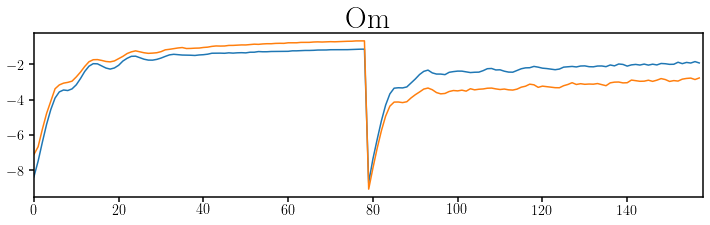

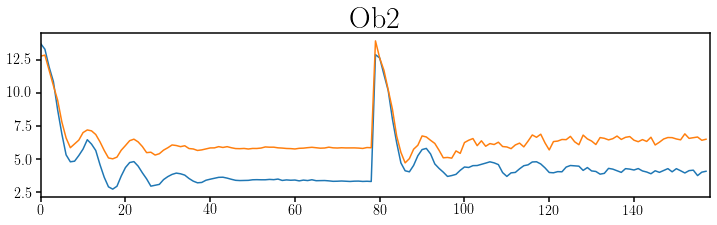

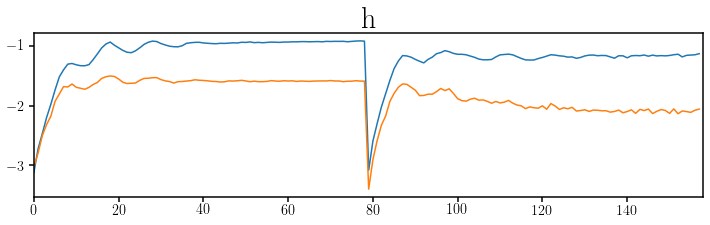

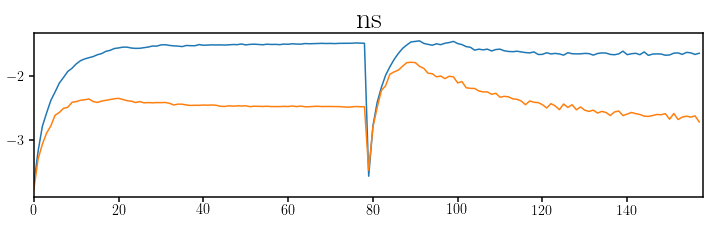

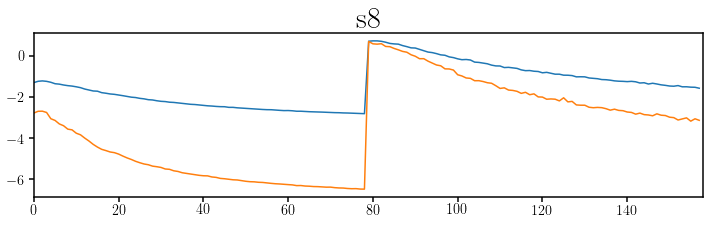

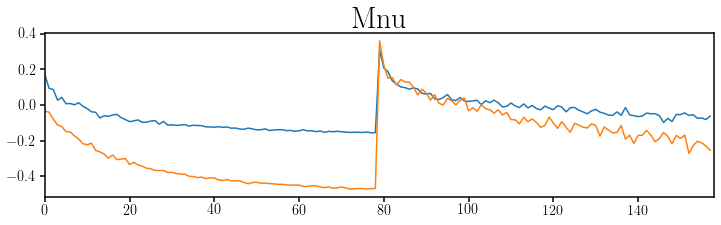

In [5]:
for theta in ['Om', 'Ob2', 'h', 'ns', 's8', 'Mnu']:
    fig = plt.figure(figsize=(12,3))
    sub = fig.add_subplot(111)
    db = dObsdtheta('pk', theta, 0.5, z=1.0, log=True)
    sub.plot(db)
    db = dObsdtheta('pk', theta, 0.5, z=2.0, log=True)
    sub.plot(db)
    sub.set_xlim(0, len(db))
    sub.set_title('%s' % theta, fontsize=30)
    plt.show()

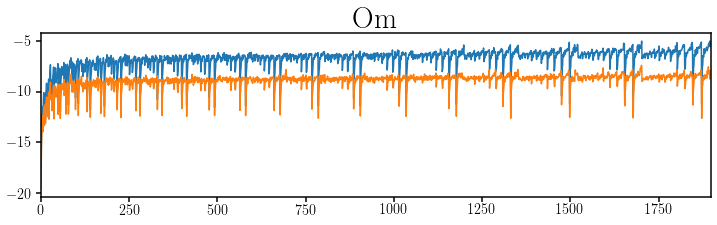

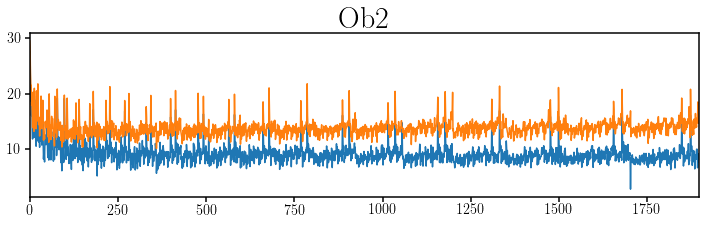

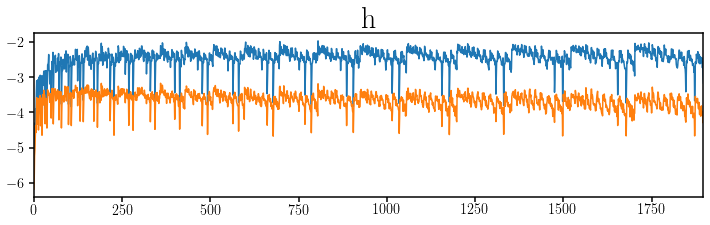

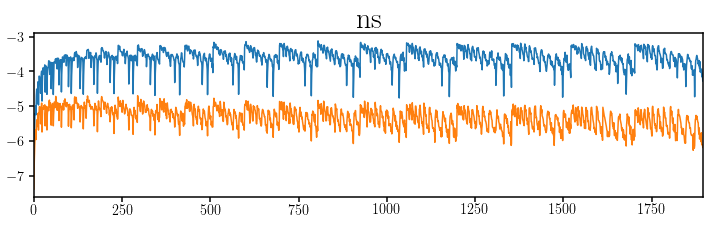

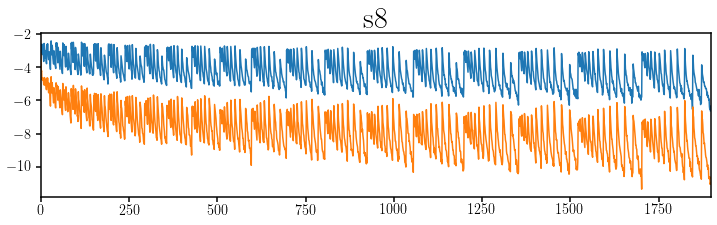

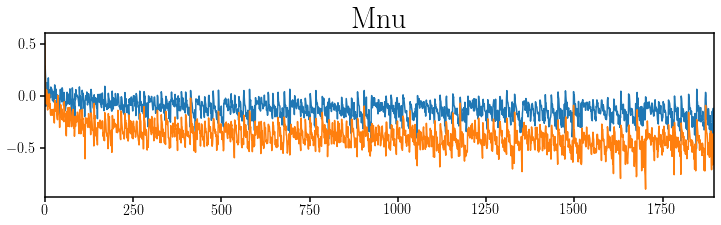

In [6]:
for theta in ['Om', 'Ob2', 'h', 'ns', 's8', 'Mnu']:
    fig = plt.figure(figsize=(12,3))
    sub = fig.add_subplot(111)
    db = dObsdtheta('bk', theta, 0.5, z=1.0, log=True)
    sub.plot(db)
    db = dObsdtheta('bk', theta, 0.5, z=2.0, log=True)
    sub.plot(db)    
    sub.set_xlim(0, 1897)#len(db))
    sub.set_title('%s' % theta, fontsize=30)
    plt.show()

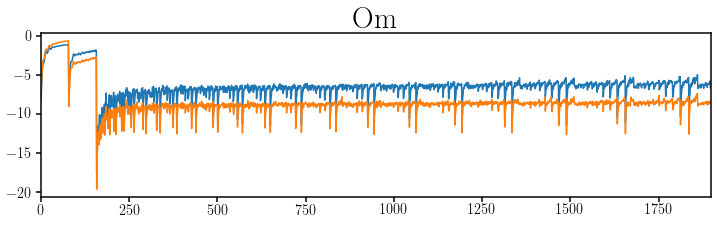

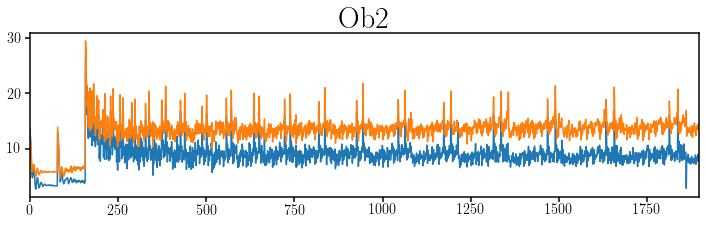

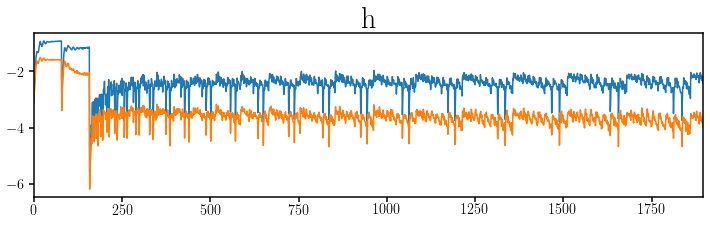

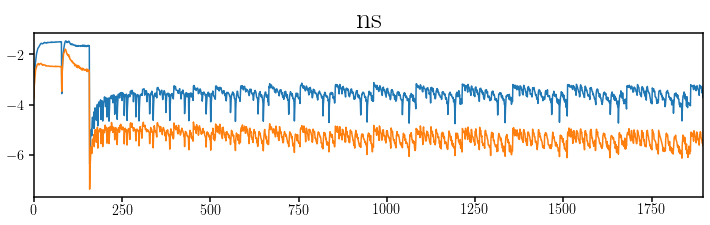

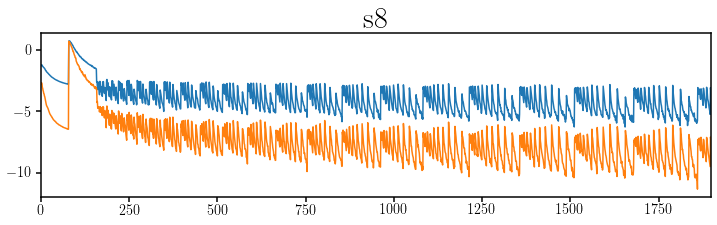

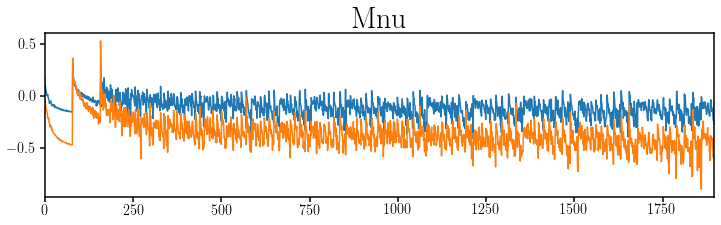

In [7]:
for theta in ['Om', 'Ob2', 'h', 'ns', 's8', 'Mnu']:
    fig = plt.figure(figsize=(12,3))
    sub = fig.add_subplot(111)
    db = dObsdtheta('pkbk', theta, 0.5, z=1.0, log=True)
    sub.plot(db)
    db = dObsdtheta('pkbk', theta, 0.5, z=2.0, log=True)
    sub.plot(db)    
    sub.set_xlim(0, 1897)#len(db))
    sub.set_title('%s' % theta, fontsize=30)
    plt.show()

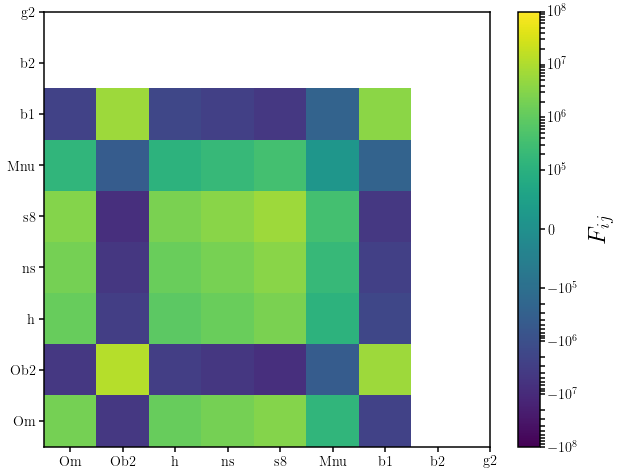

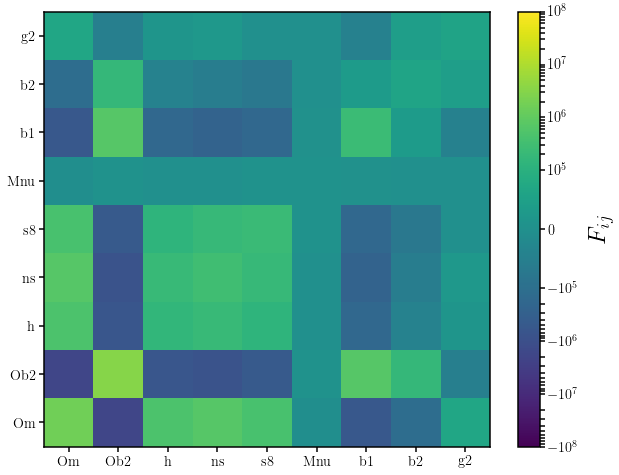

In [8]:
# plot the covariance matrix
Fij = FisherMatrix('pk', kmax=0.5, z=1.0, include_bias=True)

fig = plt.figure(figsize=(10,8))
sub = fig.add_subplot(111)
cm = sub.pcolormesh(Fij, norm=SymLogNorm(vmin=-1e8, vmax=1e8, linthresh=1e5))
cbar = fig.colorbar(cm, ax=sub)
cbar.set_label(r'$F_{ij}$',fontsize=25, labelpad=10, rotation=90)

sub.set_xticks(np.arange(9)+0.5)
_ = sub.set_xticklabels(['Om', 'Ob2', 'h', 'ns', 's8', 'Mnu', 'b1', 'b2', 'g2'])
sub.set_yticks(np.arange(9)+0.5)
_ = sub.set_yticklabels(['Om', 'Ob2', 'h', 'ns', 's8', 'Mnu', 'b1', 'b2', 'g2'])
plt.show()

Fij = FisherMatrix('bk', kmax=0.5, z=1.0, include_bias=True)

fig = plt.figure(figsize=(10,8))
sub = fig.add_subplot(111)
cm = sub.pcolormesh(Fij, norm=SymLogNorm(vmin=-1e8, vmax=1e8, linthresh=1e5))
cbar = fig.colorbar(cm, ax=sub)
cbar.set_label(r'$F_{ij}$',fontsize=25, labelpad=10, rotation=90)

sub.set_xticks(np.arange(9)+0.5)
_ = sub.set_xticklabels(['Om', 'Ob2', 'h', 'ns', 's8', 'Mnu', 'b1', 'b2', 'g2'])
sub.set_yticks(np.arange(9)+0.5)
_ = sub.set_yticklabels(['Om', 'Ob2', 'h', 'ns', 's8', 'Mnu', 'b1', 'b2', 'g2'])

In [10]:
print('kmax = 0.5; z=1.0')
sig0 = forecast('pk', z=1., include_bias=True, planck=False)
sig1 = forecast('bk', z=1., include_bias=True, planck=False)

for tt, fimprove in zip(['Om', 'Ob', 'h', 'ns', 's8', 'Mnu'], (sig1[:6] / sig0[:6])): 
    print(tt, fimprove)

kmax = 0.5; z=1.0
Om 0.37390203884674644
Ob 0.31738597569181415
h 0.2318023988423551
ns 0.22327201007682315
s8 0.6464840759889038
Mnu 0.16457936862990719


In [11]:
print('kmax = 0.5; z=1.0; w/ Planck')
sig0 = forecast('pk', z=1., include_bias=True, planck=True)
sig1 = forecast('bk', z=1., include_bias=True, planck=True)

for tt, fimprove in zip(['Om', 'Ob', 'h', 'ns', 's8', 'Mnu'], (sig1[:6] / sig0[:6])): 
    print(tt, fimprove)

kmax = 0.5; z=1.0; w/ Planck
Om 0.8298139049442126
Ob 0.8391132939454313
h 0.9261596077914449
ns 0.8877582503902687
s8 1.070774548885921
Mnu 0.42643757969515184


In [12]:
print('kmax = 0.5; z=2.0')
sig0 = forecast('pk', z=2., include_bias=True, planck=False)
sig1 = forecast('bk', z=2., include_bias=True, planck=False)

for tt, fimprove in zip(['Om', 'Ob', 'h', 'ns', 's8', 'Mnu'], (sig1[:6] / sig0[:6])): 
    print(tt, fimprove)

kmax = 0.5; z=2.0
Om 0.45100657780866654
Ob 0.2935019276191496
h 0.2605944064772096
ns 0.21243648078327187
s8 0.45504398665547435
Mnu 0.14729835942684225


In [17]:
print('kmax = 0.5; z=2.0; w/ planck')
sig0 = forecast('pk', z=2., include_bias=True, planck=True)
sig1 = forecast('bk', z=2., include_bias=True, planck=True)

for tt, fimprove in zip(['Om', 'Ob', 'h', 'ns', 's8', 'Mnu'], (sig1[:6] / sig0[:6])): 
    print(tt, fimprove)

kmax = 0.5; z=2.0; w/ planck
Om 0.7437776034965209
Ob 0.7811352746394578
h 0.852353967723176
ns 0.8336760695348306
s8 0.864438244363352
Mnu 0.3585124592485092


In [15]:
print('kmax = 0.2; z=1.0')
sig0 = forecast('pk', z=1., kmax=0.2, include_bias=True, planck=False)
sig1 = forecast('bk', z=1., kmax=0.2, include_bias=True, planck=False)

for tt, fimprove in zip(['Om', 'Ob', 'h', 'ns', 's8', 'Mnu'], (sig1[:6] / sig0[:6])): 
    print(tt, fimprove)

kmax = 0.2; z=1.0
Om 0.5237131078769337
Ob 0.5080918299857553
h 0.44167801360606157
ns 0.4804090562615918
s8 1.4759573692353543
Mnu 0.4211303071598001


In [16]:
print('kmax = 0.2; z=1.0; w/ planck')
sig0 = forecast('pk', z=1., kmax=0.2, include_bias=True, planck=True)
sig1 = forecast('bk', z=1., kmax=0.2, include_bias=True, planck=True)

for tt, fimprove in zip(['Om', 'Ob', 'h', 'ns', 's8', 'Mnu'], (sig1[:6] / sig0[:6])): 
    print(tt, fimprove)

kmax = 0.2; z=1.0; w/ planck
Om 1.4468566207607647
Ob 1.2565549317062072
h 1.2778135338574235
ns 1.0428684225527869
s8 1.5345086668411085
Mnu 1.12255138746566


In [18]:
print('kmax = 0.2; z=2.0')
sig0 = forecast('pk', z=2., kmax=0.2, include_bias=True, planck=False)
sig1 = forecast('bk', z=2., kmax=0.2, include_bias=True, planck=False)

for tt, fimprove in zip(['Om', 'Ob', 'h', 'ns', 's8', 'Mnu'], (sig1[:6] / sig0[:6])): 
    print(tt, fimprove)

kmax = 0.2; z=2.0
Om 0.8246584292665043
Ob 0.723656634450914
h 0.5453045160717068
ns 0.519688096302349
s8 0.762483715916027
Mnu 0.33258354663713297


In [19]:
print('kmax = 0.2; z=2.0; w/ planck')
sig0 = forecast('pk', z=2., kmax=0.2, include_bias=True, planck=True)
sig1 = forecast('bk', z=2., kmax=0.2, include_bias=True, planck=True)

for tt, fimprove in zip(['Om', 'Ob', 'h', 'ns', 's8', 'Mnu'], (sig1[:6] / sig0[:6])): 
    print(tt, fimprove)

kmax = 0.2; z=2.0; w/ planck
Om 1.5857686703878793
Ob 1.4925916821984895
h 1.4928846439508854
ns 1.0687891927263362
s8 1.7797797069657486
Mnu 1.1525493944782503


In [9]:
forecast(include_bias=False)

sigma_Om 3.32e-03
sigma_Ob2 1.22e-03
sigma_h 1.10e-02
sigma_ns 1.08e-02
sigma_s8 3.70e-03
sigma_Mnu 1.49e-02


In [11]:
forecast(z=2.0, include_bias=True)

sigma_Om 4.07e-03
sigma_Ob2 1.30e-03
sigma_h 1.24e-02
sigma_ns 1.13e-02
sigma_s8 4.86e-03
sigma_Mnu 1.29e-02


In [12]:
forecast(z=2.0, include_bias=False)

sigma_Om 3.62e-03
sigma_Ob2 1.30e-03
sigma_h 1.23e-02
sigma_ns 1.06e-02
sigma_s8 4.64e-03
sigma_Mnu 1.29e-02


In [16]:
z = 1.
f = h5py.File(os.path.join('/tigress/chhahn/emanu/bk', 'b0k.rsd2.fiducial.z%.1f.hdf5' % z), 'r')
print(np.mean(f['Nhalos'][...])/ 1e9)
f.close()

0.000183044522


In [18]:
z = 2.
f = h5py.File(os.path.join('/tigress/chhahn/emanu/bk', 'b0k.rsd2.fiducial.z%.1f.hdf5' % z), 'r')
print(np.mean(f['Nhalos'][...])/ 1e9)
f.close()

4.0296995866666666e-05
